# Reinforcement Learning for Self-Driving Car Simulation

**Student Name:** [Your Name Here]
**Course:** [Your Course Name Here]
**Assignment:** Project on Reinforcement Learning

This notebook implements the **Q-Learning** algorithm to solve a simplified self-driving car environment, modeled as a Gridworld.


In [1]:
# Import necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. The Environment

We will create a `DrivingGridworld` class. This class represents the "world" our car drives in. It handles the rules, rewards, and state transitions.

* **States:** 25 states (a 5x5 grid).
* **Actions:** 4 possible actions (UP, RIGHT, DOWN, LEFT).
* **Rewards:**
    * 'G' (Goal): **+10** (at position 0, 4)
    * 'X' (Collision): **-10** (at 3,1 and 3,2)
    * 'x' (Traffic): **-1** (at 2,1 and 2,2)
    * '.' (Empty Road): **-0.1** (This is a small "time penalty" for every step, encouraging the car to find the **fastest** route).

Our grid looks like this:

'[ . , . , . , . , G ]'
'[ . , . , . , . , . ]'
'[ . , x , x , . , . ]'
'[ . , X , X , . , . ]'
'[ S , . , . , . , . ]' (Start is at 4,0)

In [2]:
# --- 1. Environment Setup (Simplified Gridworld) ---
class DrivingGridworld:
    """
    A 2D grid environment simulating a simplified road network.
    """
    def __init__(self):
        # Define the grid structure and rewards
        self.grid = np.array([
            [0, 0, 0, 0, 10], # Row 0: Goal is (0, 4) with +10 reward
            [0, 0, 0, 0, 0],  # Row 1
            [0, -1, -1, 0, 0], # Row 2: Obstacles/Bad Traffic at (2, 1), (2, 2)
            [0, -10, -10, 0, 0], # Row 3: Major Obstacles/Collision Zone at (3, 1), (3, 2)
            [-1, 0, 0, 0, 0] # Row 4: Start is (4, 0)
        ])
        self.rows, self.cols = self.grid.shape
        self.start_state = (4, 0)
        self.current_state = self.start_state
        self.n_states = self.rows * self.cols # 5x5 = 25 states
        self.n_actions = 4 # 4 possible actions

        # Map action indices (0-3) to (row_change, col_change)
        self.action_map = {
            0: (-1, 0),  # Up
            1: (0, 1),   # Right
            2: (1, 0),   # Down
            3: (0, -1)   # Left
        }

    def reset(self):
        """Resets the environment to the starting state for a new episode."""
        self.current_state = self.start_state
        # Return the state as a single index
        return self.state_to_index(self.current_state)

    def state_to_index(self, state):
        """Converts (row, col) state to a single index (0-24)."""
        # (row * num_cols) + col
        return state[0] * self.cols + state[1]

    def index_to_state(self, index):
        """Converts a single index (0-24) back to (row, col)."""
        return (index // self.cols, index % self.cols)

    def is_terminal(self, state):
        """Checks if a state is terminal (Goal or Crash)."""
        r, c = state
        return self.grid[r, c] == 10 or self.grid[r, c] == -10

    def step(self, action_index):
        """
        Takes an action, updates the state, and returns the result.
        Returns: (next_state, reward, done)
        """
        r, c = self.current_state
        dr, dc = self.action_map[action_index]
        next_r, next_c = r + dr, c + dc

        # Check for boundaries (if car tries to drive off the grid, it stays put)
        if 0 <= next_r < self.rows and 0 <= next_c < self.cols:
            next_state_tuple = (next_r, next_c)
        else:
            next_state_tuple = self.current_state

        # Get the reward for the new state from the grid
        reward = self.grid[next_state_tuple[0], next_state_tuple[1]]

        # Add the small step penalty to encourage efficiency
        step_penalty = -0.1
        reward += step_penalty

        # Update the car's current position
        self.current_state = next_state_tuple
        
        # Check if the new state is a terminal state
        done = self.is_terminal(self.current_state)
        
        # Convert the (r, c) tuple to a single state index
        next_state_index = self.state_to_index(self.current_state)

        return next_state_index, reward, done

print("DrivingGridworld class defined. Run this cell to load it into memory.")


DrivingGridworld class defined. Run this cell to load it into memory.


## 2. The Q-Learning Agent

Now we define the "brain" of our car, the `QLearningAgent`. This class is responsible for:
1.  **The Q-Table**: A big lookup table (`states` x `actions`) that stores the "Quality" (expected future reward) of taking any action in any state.
2.  **Choosing Actions**: Using the "Epsilon-Greedy" strategy to balance exploring new actions vs. exploiting known good actions.
3.  **Learning**: Using the Q-Learning update rule (the Bellman Equation) to update the Q-Table after each step.


In [3]:
# --- 2. Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay_rate=0.999):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = learning_rate         # ALPHA: How much we update from new info
        self.gamma = discount_factor    # GAMMA: How much we value future rewards
        self.epsilon = exploration_rate  # EPSILON: Initial chance of exploring
        self.min_epsilon = min_exploration_rate
        self.epsilon_decay = exploration_decay_rate
        
        # Initialize the Q-table with all zeros
        # Shape: (25 states, 4 actions)
        self.q_table = np.zeros((n_states, n_actions))

    def choose_action(self, state):
        """
        Chooses an action using the Epsilon-Greedy strategy.
        """
        # Generate a random number between 0 and 1
        if random.uniform(0, 1) < self.epsilon:
            # EXPLORE: Choose a random action
            return random.randint(0, self.n_actions - 1)
        else:
            # EXPLOIT: Choose the best known action (from Q-table)
            # np.argmax returns the *index* of the maximum value
            return np.argmax(self.q_table[state, :])

    def update_q_value(self, state, action, reward, next_state):
        """
        Updates the Q-value for the (state, action) pair using the Q-learning formula:
        Q(s, a) <- Q(s, a) + alpha * [ R + gamma * max_a' Q(s', a') - Q(s, a) ]
        """
        
        # Find the best possible Q-value for the *next* state
        # This is the "max_a' Q(s', a')" part
        max_future_q = np.max(self.q_table[next_state, :])

        # Get the current Q-value for our (state, action) pair
        # This is the "Q(s, a)" part
        current_q = self.q_table[state, action]

        # Calculate the "TD Target" - what the new Q-value *should* be
        # This is the "R + gamma * max_future_q" part
        td_target = reward + self.gamma * max_future_q
        
        # Calculate the "TD Error" - the difference between what it should be and what it is
        # This is "td_target - current_q"
        td_error = td_target - current_q

        # Update the Q-value using the learning rate (alpha)
        # This is the full Q-Learning rule
        self.q_table[state, action] = current_q + self.lr * td_error

    def decay_epsilon(self):
        """
        Reduces the exploration rate (epsilon) over time,
        so the agent exploits more as it learns.
        """
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

print("QLearningAgent class defined. Run this cell to load it.")


QLearningAgent class defined. Run this cell to load it.


## 3. The Training Loop

This function manages the entire training process. It:
1.  Runs for a specified number of "episodes" (e.g., 10,000 runs).
2.  In each episode, it will `reset` the environment.
3.  It will loop, taking one `step` at a time, until the car `Crashes` or reaches the `Goal`.
4.  Inside the loop, it performs the core **[Act -> Observe -> Learn]** cycle.
5.  It tracks the total reward for each episode so we can plot it.

In [4]:
# --- 3. Training Loop ---
def train_agent(env, agent, num_episodes=5000):
    """
    Runs the Q-Learning training process for a given number of episodes.
    """
    reward_history = [] # To store total reward per episode

    print(f"Starting Q-Learning Training for {num_episodes} episodes...")

    # The outer loop: run for N episodes
    for episode in range(num_episodes):
        # Start a new episode by resetting the environment
        state = env.reset()
        done = False
        total_reward = 0
        step_count = 0

        # The inner loop: run until the episode is done (goal or crash)
        while not done:
            # 1. ACT: Agent chooses an action
            action = agent.choose_action(state)

            # 2. OBSERVE: Environment gives back next state, reward, and done status
            next_state, reward, done = env.step(action)

            # 3. LEARN: Agent learns from this experience
            agent.update_q_value(state, action, reward, next_state)

            # 4. Update for next loop
            state = next_state
            total_reward += reward
            step_count += 1

            # Safety break: prevent infinite loops if policy is bad
            if step_count > 200:
                break

        # Episode finished: decay epsilon and record the total reward
        agent.decay_epsilon()
        reward_history.append(total_reward)

        # Print progress every 500 episodes
        if (episode + 1) % 500 == 0:
            print(f"Episode: {episode + 1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.4f}")

    print("\nTraining Finished.")
    return reward_history, agent.q_table

print("train_agent function defined. Run this cell to load it.")


train_agent function defined. Run this cell to load it.


## 4. Visualization

After training, the Q-Table is just a big block of numbers. To understand what the agent learned, we need to visualize it. This function will:
1.  Print the final Q-Table.
2.  Extract the "Optimal Policy": For each state, it finds the action with the highest Q-value.
3.  Print this policy as a human-readable grid (e.g., `START -> UP`).
4.  Plot the `reward_history` to show the learning curve.

In [5]:
# --- 4. Policy Extraction and Visualization ---
def visualize_results(env, reward_history, q_table):
    """
    Prints the final Q-table, the optimal policy, and plots the learning curve.
    """
    print("\n--- Final Learned Q-Table (State Index vs Action [Up, Right, Down, Left]) ---")
    np.set_printoptions(precision=3, suppress=True) # Makes the numbers print cleanly
    print(q_table)

    print("\n--- Optimal Policy (Best Action per State) ---")
    # This finds the action (index 0-3) with the max Q-value for each state (row 0-24)
    policy = np.argmax(q_table, axis=1) 
    
    action_names = {0: 'UP   ', 1: 'RIGHT', 2: 'DOWN ', 3: 'LEFT '}

    # Reshape the 1D policy (25,) into a 2D grid (5, 5) for printing
    policy_grid = np.zeros((env.rows, env.cols), dtype=object)
    
    for i in range(env.n_states):
        r, c = env.index_to_state(i)
        policy_grid[r, c] = action_names[policy[i]]

    # Add labels for Start, Goal, and Crash for clarity
    policy_grid[env.grid == 10] = 'GOAL'
    policy_grid[env.grid == -10] = 'CRASH'
    policy_grid[env.start_state] = 'START'

    print("The learned optimal policy grid:")
    print(policy_grid)

    # Plot the learning curve
    print("\n--- Learning Curve (Total Reward per Episode) ---")
    
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history)
    plt.title('Q-Learning: Total Reward per Episode (Car Learning Curve)', fontsize=14)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Total Accumulated Reward', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show() # This command displays the plot in Jupyter

print("visualize_results function defined. Run this cell to load it.")

visualize_results function defined. Run this cell to load it.


## 5. Main Execution: Run the Simulation!

This final block brings everything together.
1.  Creates an instance of our `DrivingGridworld`.
2.  Creates an instance of our `QLearningAgent`.
3.  Runs the `train_agent` function with our env and agent.
4.  Passes the results (`history`, `final_q_table`) to the `visualize_results` function.

This is the cell you run to start the whole experiment!


Starting Q-Learning Training for 10000 episodes...
Episode: 500/10000 | Total Reward: 7.90 | Epsilon: 0.7788
Episode: 1000/10000 | Total Reward: 8.70 | Epsilon: 0.6065
Episode: 1500/10000 | Total Reward: 6.70 | Epsilon: 0.4723
Episode: 2000/10000 | Total Reward: 9.10 | Epsilon: 0.3678
Episode: 2500/10000 | Total Reward: 8.50 | Epsilon: 0.2864
Episode: 3000/10000 | Total Reward: 7.60 | Epsilon: 0.2230
Episode: 3500/10000 | Total Reward: 9.20 | Epsilon: 0.1737
Episode: 4000/10000 | Total Reward: 9.20 | Epsilon: 0.1353
Episode: 4500/10000 | Total Reward: 9.20 | Epsilon: 0.1053
Episode: 5000/10000 | Total Reward: 9.20 | Epsilon: 0.0820
Episode: 5500/10000 | Total Reward: 9.20 | Epsilon: 0.0639
Episode: 6000/10000 | Total Reward: 8.20 | Epsilon: 0.0497
Episode: 6500/10000 | Total Reward: 9.20 | Epsilon: 0.0387
Episode: 7000/10000 | Total Reward: 9.20 | Epsilon: 0.0302
Episode: 7500/10000 | Total Reward: 9.20 | Epsilon: 0.0235
Episode: 8000/10000 | Total Reward: 9.20 | Epsilon: 0.0183
Episod

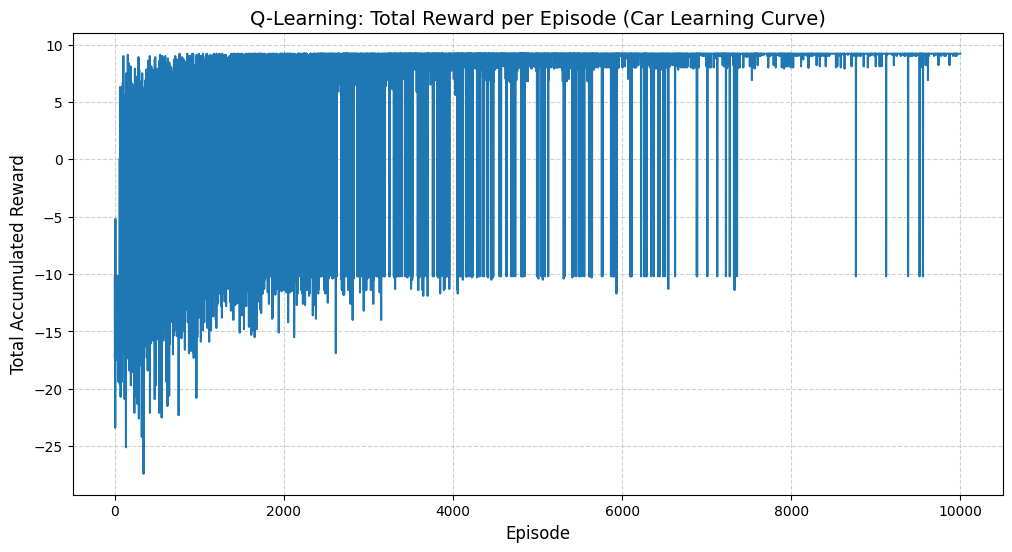

In [6]:
# --- Main Execution ---

# 1. Initialize Environment
env = DrivingGridworld()

# 2. Initialize Agent
# We pass in the state and action counts from the environment
agent = QLearningAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    learning_rate=0.1,
    discount_factor=0.9,
    exploration_rate=1.0,         # Start at 100% exploration
    exploration_decay_rate=0.9995 # Decay slowly
)

# 3. Train the Agent
# We'll use 10,000 episodes for good convergence. This may take 10-20 seconds.
history, final_q_table = train_agent(env, agent, num_episodes=10000)

# 4. Analyze and Visualize Results
visualize_results(env, history, final_q_table)
